In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
train = '/mnt/NewVolume/DUMP/Notebook/xray_analytics_cnn/data/BoneFractureDataset/training'
test = '/mnt/NewVolume/DUMP/Notebook/xray_analytics_cnn/data/BoneFractureDataset/testing'

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#Preprocessing

In [4]:
def scale_images(x, y):
    return x / 255, y

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="categorical", validation_split=0.2, subset="training",seed=42)
train_data = train_data.map(scale_images)
train_size = int(len(train_data))
train_data_final = train_data.take(train_size)
print(train_size)

Found 8863 files belonging to 2 classes.
Using 7091 files for training.
222


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(train, image_size=(256, 256), labels="inferred", label_mode="categorical", validation_split=0.2, subset="validation", seed=42)
val_data = val_data.map(scale_images)
val_data_final = val_data.take(len(val_data))
print(len(val_data))

Found 8863 files belonging to 2 classes.
Using 1772 files for validation.
56


In [7]:
#VGG16

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layers in resnet50_model.layers:
    layers.trainable = False

model = Sequential()

model.add(resnet50_model)

model.add(Flatten())

model.add(Dense(64, activation='tanh'))

model.add(Dense(1, activation='sigmoid'))

cus_optimizer = Adam(learning_rate = 1e-5)

model.compile(optimizer=cus_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 64)                8388672   
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 31,976,514
Trainable params: 8,388,802
Non-trainable params: 23,587,712
_________________________________________________________________


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_data_final, epochs=10, validation_data=val_data_final, callbacks=[early_stopping],verbose=0)

Epoch 1/10
222/222 [==============================] - 31s 130ms/step - loss: 0.6824 - accuracy: 0.5532 - val_loss: 0.6415 - val_accuracy: 0.6552
Epoch 2/10
222/222 [==============================] - 29s 128ms/step - loss: 0.6395 - accuracy: 0.6204 - val_loss: 0.6066 - val_accuracy: 0.6828
Epoch 3/10
222/222 [==============================] - 29s 128ms/step - loss: 0.6131 - accuracy: 0.6594 - val_loss: 0.5905 - val_accuracy: 0.7020
Epoch 4/10
222/222 [==============================] - 29s 128ms/step - loss: 0.5989 - accuracy: 0.6721 - val_loss: 0.5833 - val_accuracy: 0.7082
Epoch 5/10
222/222 [==============================] - 29s 128ms/step - loss: 0.5921 - accuracy: 0.6785 - val_loss: 0.5721 - val_accuracy: 0.7173
Epoch 6/10
222/222 [==============================] - 29s 128ms/step - loss: 0.5693 - accuracy: 0.7070 - val_loss: 0.5656 - val_accuracy: 0.7331
Epoch 7/10
222/222 [==============================] - 29s 128ms/step - loss: 0.5692 - accuracy: 0.7074 - val_loss: 0.5456 - val_ac

In [13]:
model.save("resnet_opt.h5")

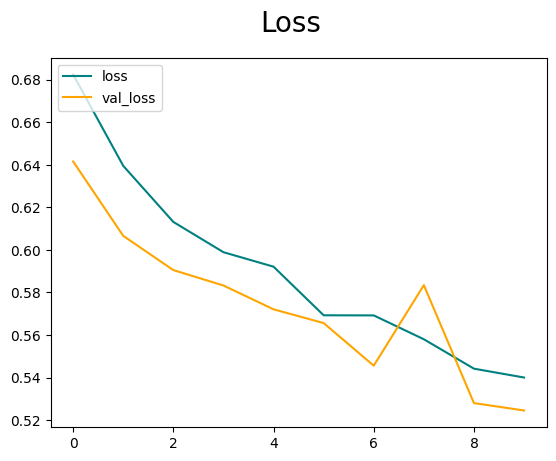

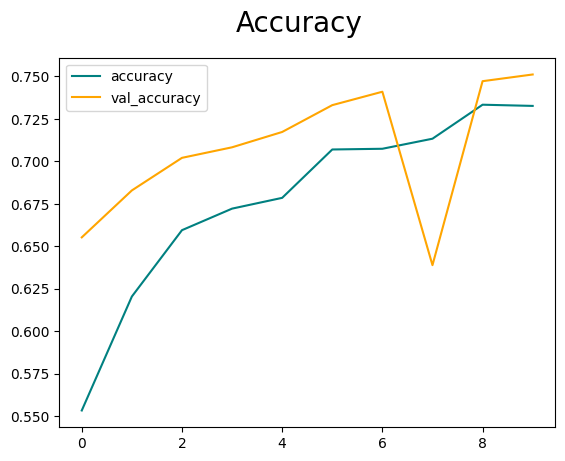

In [14]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()